In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import zss    #pip install zss
import xml.etree.ElementTree as ET


In [3]:
def get_children(node):
    my_children = [child for child in node]
    return my_children

    
def get_label(node):
    my_label = [child.tag for child in node]
    return my_label

def xmltree_dist(xml_1,xml_2):
    if xml_1==xml_2:
        return 0.0
    else:
        d  = zss.simple_distance(ET.parse(xml_1).getroot(),ET.parse(xml_2).getroot(),get_children,get_label)
    return d
#pass path_to_xmls
#xml_1 = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/Data/Contest1236/all_xml/29091733_62799939.xml'
#xml_2 = '/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/Data/Contest1236/all_xml/29087161_62785968.xml'
#d=xmltree_dist(xml_1,xml_2)
#print(d)





    
#def true_group(f):
#    if f in group_expert_stats['file_name_problem_C'].tolist():
#        return 0
#    else:
#        return 1
    










def pick_sample(contest,problem,n,cat):
    stats = pd.read_csv("./Data/"+str(contest)+"/standings_statistics.csv",delimiter='\t')
    stats = stats.loc[stats['ProblemC_language'] == 'GNU C++17']
    
    

    
    
    stats['file_name_problem_A'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemA_id'].astype(str)+".xml"
    stats['file_name_problem_B'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemB_id'].astype(str)+".xml"
    stats['file_name_problem_C'] = stats['ParticipantID'].astype(str)+"_"+stats['ProblemC_id'].astype(str)+".xml"
    group_expert_stats = stats[:50]
    group_noob_stats = stats[len(stats):len(stats)-50:-1]
    
    f_names_A = stats['file_name_problem_A'].tolist()
    f_names_B = stats['file_name_problem_B'].tolist()
    f_names_C = stats['file_name_problem_C'].tolist()
    if cat=='rank':
        f_names_top = group_expert_stats['file_name_'+str(problem)].tolist()[:n]
        f_names_bottom = group_noob_stats['file_name_'+str(problem)].tolist()[:n]
        f_names_sample = f_names_top+f_names_bottom
    #memory based 
#    else if cat=='mem':
#        f_names_top = group_expert_stats['file_name_'+str(problem)].tolist()[:n]
#        f_names_bottom = group_noob_stats['file_name_'+str(problem)].tolist()[:n]
#        f_names_sample = f_names_top+f_names_bottom
#        
        
        print("input xmls set up complete")
    return f_names_sample
    



#computes similarity matrix
def similarity_xml_tree_dist(f_s,contest):
    similarity = {}
    for i in range(len(f_s)):
        for j in range(len(f_s)):
            if i<=j:
                if f_s[i] in similarity.keys():
                    similarity[f_s[i]].append(xmltree_dist('./Data/'+str(contest)+'/all_xml/'+str(f_s[i]),'./Data/'+str(contest)+'/all_xml/'+str(f_s[j])))
                else:
                    similarity[f_s[i]] = [xmltree_dist('./Data/'+str(contest)+'/all_xml/'+str(f_s[i]),'./Data/'+str(contest)+'/all_xml/'+str(f_s[j]))]
            else:
                if f_s[i] in similarity.keys():
                    similarity[f_s[i]].append(similarity[f_s[j]][f_s.index(f_s[i])])
                else:
                    similarity[f_s[i]]=[similarity[f_s[j]][f_s.index(f_s[i])]]
            print(str(i)+","+str(j)+" done!")
        print(str(i+1)+" out of "+str(len(f_s))+" files done!")
    similarity_matrix = pd.DataFrame.from_dict(similarity,orient='index',columns=f_s) 
    return similarity_matrix
            






In [4]:
#---------DRIVER-----------------------------

contest = 'Contest1236'
problem = 'problem_C'
n_sample = 13   # n sample from top + n sample from bottom

f_names_sample = pick_sample(contest,problem,n_sample,'rank')




input xmls set up complete


In [ ]:
print("Computing similarity matrix...................")
sim = similarity_xml_tree_dist(f_names_sample,contest)

print("Similarity matrix computation complete")
sim.to_csv("similarity_matrix_sample_"+str(contest)+"_"+str(problem)+".csv")


In [5]:
#For analysis use this (already saved csvs)

In [6]:
sim = pd.read_csv("similarity_matrix_sample_"+str(contest)+"_"+str(problem)+".csv")

Contest1236_problem_C


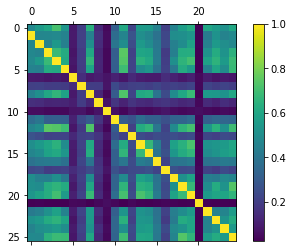

In [8]:
sim = sim.iloc[:,1:]
#------------plot similarity matrix
import copy
l = copy.deepcopy(sim)
l = np.array(l)
sigma = 18
l = np.exp(-l/sigma**2)
import matplotlib.pyplot as plt

print(str(contest)+"_"+str(problem))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(l)
fig.colorbar(cax)
plt.show()


In [ ]:
#sim.to_csv("similarity_matrix_sample_prob_C.csv")





#use this for analysis
#sim = pd.read_csv("/home/ashish-j/workspace/Data_Analytics/Project/project_local_work/E0259_Project/similarity_matrix_sample_prob_C.csv")
#print("csv_saved")



#how similarity matrix looks?

#
#
#sim.head(5)
#
#
#
#sim = sim.iloc[:,1:]




##clustering



#-----------------------CLUSETRING-----------------------------------------------------------
#print("clustering......................")
#from sklearn.cluster import SpectralClustering
#
#
#
##Affinity matrix l (like in Data Analytics assignemnt but just here distance is tree edit distance)
#
#
#
#
#clustering = SpectralClustering(n_clusters=3,
#        assign_labels="discretize",affinity='precomputed',
#        random_state=0).fit(l)




